In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import torch
import pickle
import warnings
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/papers.csv')
print(df.shape)
df.head()

(7241, 7)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [3]:
df.isna().sum()

id               0
year             0
title            0
event_type    4819
pdf_name         0
abstract         0
paper_text       0
dtype: int64

In [4]:
list(np.array(df['abstract'])).count('Abstract Missing')

3317

# Preprocessing

In [5]:
# merge title and abstract
df['text']=df.apply(lambda x: x['title']+((' ' + x['abstract']) if x['abstract']!='Abstract Missing' else ''), axis=1)
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,Self-Organization of Associative Database and ...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,A Mean Field Theory of Layer IV of Visual Cort...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,Storing Covariance by the Associative Long-Ter...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,Bayesian Query Construction for Neural Network...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","Neural Network Ensembles, Cross Validation, an..."


In [6]:
data = df[['year','text']]
data.head()

,year,text
0,1987,Self-Organization of Associative Database and ...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...
2,1988,Storing Covariance by the Associative Long-Ter...
3,1994,Bayesian Query Construction for Neural Network...
4,1994,"Neural Network Ensembles, Cross Validation, an..."


In [7]:
data["text"] = data["text"].astype(str)
data["text"] = data["text"].str.lower()
data.head()

,year,text
0,1987,self-organization of associative database and ...
1,1987,a mean field theory of layer iv of visual cort...
2,1988,storing covariance by the associative long-ter...
3,1994,bayesian query construction for neural network...
4,1994,"neural network ensembles, cross validation, an..."


In [8]:
import re
def remove_url(text):
    url_pat = re.compile(r'https?://\S+|www\.\S+')
    return url_pat.sub(r'', text)
data["text"] = data["text"].apply(lambda text: remove_url(text))
data.head()

,year,text
0,1987,self-organization of associative database and ...
1,1987,a mean field theory of layer iv of visual cort...
2,1988,storing covariance by the associative long-ter...
3,1994,bayesian query construction for neural network...
4,1994,"neural network ensembles, cross validation, an..."


In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer as wnl
lemm = wnl()
def lemm_words(text):
    return " ".join([lemm.lemmatize(word) for word in text.split()])

data["text"] = data["text"].apply(lambda text: lemm_words(text))
data.head()

[nltk_data] Downloading package wordnet to /DATA/kumar156/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,year,text
0,1987,self-organization of associative database and ...
1,1987,a mean field theory of layer iv of visual cort...
2,1988,storing covariance by the associative long-ter...
3,1994,bayesian query construction for neural network...
4,1994,"neural network ensembles, cross validation, an..."


In [10]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = set(stopwords.words('english'))
def rem_sw(text):
    return " ".join([word for word in str(text).split() if word not in sw])

data["text"] = data["text"].apply(lambda text: rem_sw(text))
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /DATA/kumar156/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,year,text
0,1987,self-organization associative database applica...
1,1987,mean field theory layer iv visual cortex appli...
2,1988,storing covariance associative long-term poten...
3,1994,bayesian query construction neural network model
4,1994,"neural network ensembles, cross validation, ac..."


# Data Intervals

In [11]:
min(data.year),max(data.year)

(1987, 2017)

In [12]:
doc = defaultdict(lambda:'')
for i in range(len(data)):
    interval = (data['year'][i] -min(data.year))//3+1
    doc[f't{interval}'] += (' ' + data['text'][i])
    #doc[f't{interval}'] += data['text'][i]

In [13]:
doc.keys()

dict_keys(['t1', 't3', 't4', 't5', 't6', 't7', 't2', 't8', 't9', 't10', 't11'])

In [14]:
print([len(doc[f't{i}']) for i in range(1,12)])

[15799, 24179, 24917, 25734, 26843, 32158, 104738, 617860, 821276, 1188958, 595982]


# Keyword extraction using Bert

In [15]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
'''
from keybert import KeyBERT
kw_model = KeyBERT('distilbert-base-nli-mean-tokens')
keywords = {}
for i in range(1,12):
    words = kw_model.extract_keywords(doc[f't{i}'], keyphrase_ngram_range=(1, 1), stop_words='english',
                                  use_mmr=True, nr_candidates=25, top_n=15)  # mmr, no candidates
    keywords[i]=[a for a,b in words]
    
    words = kw_model.extract_keywords(doc[f't{i}'], keyphrase_ngram_range=(2, 2), stop_words='english',
                                  use_mmr=True, nr_candidates=20, top_n=10)
    keywords[i]+=[a for a,b in words]

with open('keywords25_bi.pickle', 'wb') as handle:
    pickle.dump(keywords, handle, protocol=pickle.HIGHEST_PROTOCOL)  
'''

"\nfrom keybert import KeyBERT\nkw_model = KeyBERT('distilbert-base-nli-mean-tokens')\nkeywords = {}\nfor i in range(1,12):\n    words = kw_model.extract_keywords(doc[f't{i}'], keyphrase_ngram_range=(1, 1), stop_words='english',\n                                  use_mmr=True, nr_candidates=25, top_n=15)  # mmr, no candidates\n    keywords[i]=[a for a,b in words]\n    \n    words = kw_model.extract_keywords(doc[f't{i}'], keyphrase_ngram_range=(2, 2), stop_words='english',\n                                  use_mmr=True, nr_candidates=20, top_n=10)\n    keywords[i]+=[a for a,b in words]\n\nwith open('keywords25_bi.pickle', 'wb') as handle:\n    pickle.dump(keywords, handle, protocol=pickle.HIGHEST_PROTOCOL)  \n"

In [16]:
# this pickle file contain 30 monogramic keywords for each time interval: t1-t11 with keys 1 to 11.
with open('keywords30_mono.pickle', 'rb') as handle:
    keywords = pickle.load(handle)

In [17]:
# display keywords of time interval t2.
print(keywords[2])

['neurocomputer', 'orientation', 'classifiers', 'iteration', 'letterforms', 'backpropagation', 'reconfigurable', 'muscle', 'activation', 'frequency', 'sexnet', 'multiscale', 'functions', 'memorization', 'controller', 'modeling', 'cochlear', 'manipulator', 'eigenvectors', 'cues', 'dynamical', 'perceptrons', 'splining', 'retinal', 'recnorm', 'decoding', 'reliability', 'physiological', 'anna', 'search']


In [18]:
all_keywords = []
for i in range(1,12):
    all_keywords+=keywords[i]
all_keywords = list(set(all_keywords))
len(all_keywords)

276

# Degree of Visibility

We are calculate the Dov values of the keywords and the x-coordinate values of KEM matrix. In the code 'nj' represents total number of documents in the interval. The first 10 intervals contain data of 3 years each, 11th interval contains data of 2 years (processed in the else section of the code).

To get x-coordinate values, we intialize a 'val' variable, which sums up the total frequency of keyword in each interval. It is divided by the total number of documents to get average term frequency.

In [19]:
dov = np.zeros((len(all_keywords),11))
min_year = min(data.year)
C = Counter(list(np.array(df.year)))
X = []

for i in range(len(all_keywords)):
    val = 0
    for j in range(max(keywords.keys())):
        if j<10: #t1-t10 time intervals
            year = min_year+3*j
            nj =C[year]+C[year+1]+C[year+2]
            dov[i][j] = (doc[f't{j+1}'].count(all_keywords[i]))
            val+=dov[i][j]
            dov[i][j]/=nj
            
        else: # t11 time interval
            year = max(df.year)
            nj = C[year]+C[year-1]
            dov[i][j] = (doc[f't{j+1}'].count(all_keywords[i]))
            val+=dov[i][j]
            dov[i][j]/=nj
        
        dov[i][j] *= (1-0.05*(max(keywords.keys())-j))
    X.append(val/len(data))
print(dov)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00120773 0.         ... 0.00739845 0.00390456 0.00076122]
 [0.         0.         0.         ... 0.0016441  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00246615 0.         0.        ]
 [0.         0.         0.00122222 ... 0.         0.00065076 0.        ]
 [0.00157895 0.         0.00122222 ... 0.         0.         0.        ]]


# Keyword Emergence Map

The length of x and y arrays of KIM matrix should be same as the number of unique words in our keyword collection. If dod value is non-zero for a particular keyword, we are considering those words for geometric-mean in calculation of KEM matrix. 'ans' variable multiplies all the non-zero dov terms for a particular keyword and nums count the number of such dov's involved. We then take the geometric mean and append it in list Y. 

In [20]:
# 
Y = []

for i in range(len(all_keywords)):
        word = all_keywords[i]
        ans = 1
        nums = 0
        for k in range(max(keywords.keys())):
            if dov[i][k]>0:
                ans*=dov[i][k]
                nums+=1
        if nums==0:
            Y.append(0)
            continue
        Y.append(ans**(1/nums))
print(len(X),len(Y))

276 276


In [21]:
kem_mat = [(X[i],Y[i]) for i in range(len(X))]

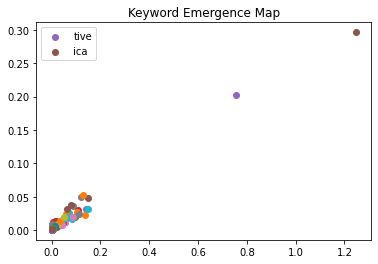

In [22]:
for i in range(len(kem_mat)):
    if kem_mat[i][0]>=0.4:
        plt.scatter(kem_mat[i][0],kem_mat[i][1],label = all_keywords[i])
        plt.legend()
        continue
    plt.scatter(kem_mat[i][0],kem_mat[i][1])
plt.title('Keyword Emergence Map')
plt.show()

# Degree of Diffusion

We are calculate the Dod values of the keywords and the x-coordinate values of KIM matrix. In the code 'nj' represents total number of documents in the interval. The first 10 intervals contain data of 3 years each, 11th interval contains data of 2 years (processed in the else section of the code).

To get x-coordinate values, we intialize a 'val' variable, which sums up the document frequency in each interval. It is divided by the total number of documents to get average document frequency.

In [23]:
dod = np.zeros((len(all_keywords),11))
X = []

for i in range(len(all_keywords)):
    val = 0
    for j in range(max(keywords.keys())):
        if j<=10:
            year = min_year+3*j
            nj =C[year]+C[year+1]+C[year+2]
            
            DF=0 # document frequency
            for ind in range(len(data)):
                if year<=data.year[ind]<year+3 and all_keywords[i] in data.text[ind]:
                    DF+=1
            val+=DF
            dod[i][j] = DF/nj
        
        else: 
            year = max(df.year)
            nj = C[year]+C[year-1]
            
            DF=0 # document frequency
            for ind in range(len(data)):
                if year-1<=data.year[ind] and all_keywords[i] in data.text[ind]:
                    DF+=1
            val+=DF
            dod[i][j] =DF/nj
        
        dod[i][j] *= (1-0.05*(max(keywords.keys())-j))
    
    X.append(val/len(data))
    
dod = np.array(dod)
print(dod)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00120773 0.         ... 0.0016441  0.00195228 0.00139912]
 [0.         0.         0.         ... 0.00082205 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0016441  0.         0.        ]
 [0.         0.         0.00122222 ... 0.         0.00065076 0.        ]
 [0.00157895 0.         0.00122222 ... 0.         0.         0.        ]]


# Keyword Issue Map

The length of x and y arrays of KIM matrix should be same as the number of unique words in our keyword collection. If dod value is non-zero for a particular keyword, we are considering those words for averaging in calculation of KIM matrix. 

In [24]:
Y = []

for i in range(len(all_keywords)):
    
        word = all_keywords[i]
        vals = [dod[i][j] for j in range(max(keywords.keys())) if dod[i][j]>0]
        if len(vals)==0:
            #print(word)
            Y.append(0)
            continue
            
        Y.append(sum(vals)/len(vals)) #averaging
print(len(X),len(Y))

276 276


In [25]:
kim_mat = [(X[i],Y[i]) for i in range(len(X))]

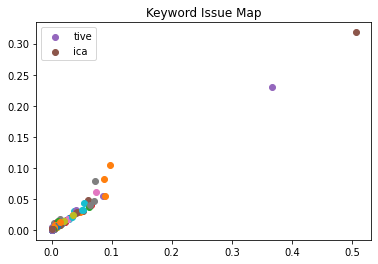

In [32]:
for i in range(len(X)):
    if X[i]>=0.1:
        plt.scatter(X[i],Y[i],label = all_keywords[i])
        plt.legend()
        continue
    plt.scatter(X[i],Y[i])
plt.title('Keyword Issue Map')
plt.show()

# Intersections

In [27]:
kem = sorted(kem_mat)
kim = sorted(kim_mat)

In [28]:
# medians

l = len(kem)
if l%2:
    medx_kem = kem[l//2][0]
    medx_kim = kim[l//2][0]
else:
    medx_kem = (kem[l//2][0]+kem[l//2-1][0])/2
    medx_kim = (kim[l//2][0]+kim[l//2-1][0])/2
    
kem = sorted(kem,key = lambda a: a[1])
kim = sorted(kim,key = lambda a: a[1])

if l%2:
    medy_kem = kem[l//2][1]
    medy_kim = kim[l//2][1]
else:
    medy_kem = (kem[l//2][1]+kem[l//2-1][1])/2
    medy_kim = (kim[l//2][1]+kim[l//2-1][1])/2

In [29]:
latent_signal = []
weak_signal = []
strong_signal = []
not_strong_but_well_known = []

for i in range(l):
    if kem_mat[i][0]>medx_kem and kim_mat[i][0]>medx_kim:
        if kem_mat[i][1]>medy_kem and kim_mat[i][1]>medy_kim:
            strong_signal.append(all_keywords[i])
            
        if kem_mat[i][1]<medy_kem and kim_mat[i][1]<medy_kim:
            not_strong_but_well_known.append(all_keywords[i])
            
    if kem_mat[i][0]<medx_kem and kim_mat[i][0]<medx_kim:
        if kem_mat[i][1]>medy_kem and kim_mat[i][1]>medy_kim:
            weak_signal.append(all_keywords[i])
            
        if kem_mat[i][1]<medy_kem and kim_mat[i][1]<medy_kim:
            latent_signal.append(all_keywords[i])

In [33]:
print('Strong signal:',strong_signal)

Strong signal: ['classify', 'auxiliary', 'probabilistic', 'physiological', 'search', 'automated', 'integration', 'routine', 'kernel', 'transductive', 'noising', 'learns', 'multivariate', 'mcmc', 'multitask', 'extraction', 'blockmodel', 'decoder', 'integrate', 'variational', 'column', 'mixture', 'reliability', 'manual', 'backpropagation', 'orientation', 'quantization', 'memory', 'analytic', 'datasets', 'grouping', 'mse', 'programming', 'frequency', 'discus', 'gate', 'hmms', 'ising', 'modelling', 'discretization', 'optimum', 'training', 'navigation', 'lstm', 'serve', 'dynamical', 'select', 'tive', 'mle', 'semidefinite', 'bipartite', 'characteristic', 'dynamic', 'filtering', 'forecasting', 'likelihood', 'copula', 'rnns', 'devise', 'ranking', 'dataset', 'multilayer', 'eigenvectors', 'ridge', 'handwritten', 'modeling', 'sensor', 'recognition', 'nonlinearities', 'hessian', 'empirical', 'convergence', 'perceptrons', 'backprop', 'minimizer', 'require', 'cognitive', 'iterative', 'patterns', 'pr

In [34]:
print('Weak signal:', weak_signal)

Weak signal: ['i100', 'kanji', 'requirements', 'gesture', 'tensorflow']


In [35]:
print('Not Strong But Well Known:',not_strong_but_well_known)

Not Strong But Well Known: ['retinal', 'anytime', 'synapse', 'classifying', 'markovian']


In [36]:
print('Latent Signal:', latent_signal)

Latent Signal: ['gaussianization', 'kbsvms', 'neurocomputer', 'zype', 'infant', 'superpixels', '1993', 'sde', 'exif', 'long_algorithms_2013', 'memorization', 'rankprop', 'stepwise', 'autoassociator', 'datamatrix', 'wavelets', 'speechreading', 'locomotory', 'multisite', 'manipulator', 'cochlear', 'dialysis', 'electroencephalographic', 'unfolding', 'emulation', 'gestures', 'anna', 'subsampled', '21578', 'muscle', 'helicopter', 'optoelectronic', 'synergistic', 'mainlifting', 'emulates', 'holistic', 'footnote', 'factorizing', 'audiometric', 'jain', 'neurophysiological', 'reconfigurable', '10184', 'accumulator', 'letterforms', 'approximability', 'lqg', 'spectrogram', 'abstracts', 'aibo', 'reconfigurability', 'kolmogorov', 'hill', 'millisecond', 'pulsestream', 'echolocating', 'benchmarking', 'phonetic', 'supermodularity', 'factorie', 'piezometer', 'sparsemax', 'simplemkl', 'wmt', 'berthet2013computational', 'eigenmaps', 'logconcave', 'subgrouping', 'blockmodels', 'matlab', 'sexnet', 'ssth', 